In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns

In [39]:
data = pd.read_csv('Diabetes.csv')
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
label_encoder = LabelEncoder()
data['Prediction'] = label_encoder.fit_transform(data['Prediction'])

In [40]:
feature_columns = data.columns.difference(['ID No', 'Name', 'Prediction']).tolist()

In [41]:
accuracy_results = []
column_importance = {col: 0 for col in feature_columns}

In [42]:
def evaluate_model(selected_columns):
    X = data[selected_columns].values
    y = data['Prediction'].values
    
    y_encoded = (y == 'DM').astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    n_qubits = len(selected_columns)
    dev = qml.device('default.qubit', wires=n_qubits)

    params = np.random.normal(0, np.pi, size=n_qubits * 2)

    @qml.qnode(dev)
    def quantum_circuit(params, x):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
        for i in range(len(params) // 2):
            qml.RY(params[2 * i], wires=i)
            if n_qubits > 1:
                qml.CNOT(wires=[i, (i + 1) % n_qubits])
            qml.RY(params[2 * i + 1], wires=(i + 1) % n_qubits)
        return qml.expval(qml.PauliZ(0))

    y_pred = np.array([quantum_circuit(params, X_train[i]) for i in range(len(X_train))])
    y_pred = (y_pred > 0).astype(int)
    
    accuracy = np.mean(y_pred == y_train)
    return accuracy

In [43]:
max_columns = len(feature_columns)
iterations = 5

In [44]:
sample = 1
for num_columns in range(1, max_columns + 1):
    for _ in range(iterations):
        if sample < 41:
            selected_columns = np.random.choice(feature_columns, size=num_columns, replace=False)
            
            accuracy = evaluate_model(selected_columns)
            
            if accuracy > 0.5 and len(selected_columns) > 2:
                
                print(f"Sample {sample}")
                print(f"\tNumber of columns: {len(selected_columns)}")
                print(f"\tAccuracy: {accuracy:.2%}")
                accuracy_results.append((selected_columns, accuracy))
                sample = sample + 1
                for col in selected_columns:
                    column_importance[col] += accuracy

Sample 1
	Number of columns: 3
	Accuracy: 51.67%
Sample 2
	Number of columns: 3
	Accuracy: 70.00%
Sample 3
	Number of columns: 3
	Accuracy: 89.17%
Sample 4
	Number of columns: 4
	Accuracy: 60.00%
Sample 5
	Number of columns: 4
	Accuracy: 73.33%
Sample 6
	Number of columns: 5
	Accuracy: 52.50%
Sample 7
	Number of columns: 5
	Accuracy: 61.67%
Sample 8
	Number of columns: 6
	Accuracy: 57.50%
Sample 9
	Number of columns: 6
	Accuracy: 58.33%
Sample 10
	Number of columns: 7
	Accuracy: 92.50%
Sample 11
	Number of columns: 7
	Accuracy: 57.50%
Sample 12
	Number of columns: 7
	Accuracy: 61.67%
Sample 13
	Number of columns: 8
	Accuracy: 55.83%
Sample 14
	Number of columns: 8
	Accuracy: 55.83%
Sample 15
	Number of columns: 8
	Accuracy: 60.83%
Sample 16
	Number of columns: 9
	Accuracy: 53.33%
Sample 17
	Number of columns: 9
	Accuracy: 54.17%
Sample 18
	Number of columns: 9
	Accuracy: 63.33%
Sample 19
	Number of columns: 10
	Accuracy: 63.33%
Sample 20
	Number of columns: 10
	Accuracy: 55.83%
Sample 

In [51]:
accuracy_results = pd.DataFrame(accuracy_results, columns=["Features", "Accuracy"])
sorted_results = accuracy_results.sort_values(by=["Accuracy"], ascending=False)
print(sorted_results)

                                             Features  Accuracy
9   [MGV, Apolipoprotein-A1, LDL, D.Bilirubin, HbA...  0.925000
2                            [SGPT, hs-CRP, GTT 1 Hr]  0.891667
33  [LPO, TGL, UricAcid, Hemoglobin, Apolipoprotei...  0.758333
38  [BUN, Alb/Crea Ratio, MGV, Apolipoprotein-B, T...  0.741667
4   [Microalbumin, TSH3, UrineCreatinine, GTT 1-1/...  0.733333
37  [P, SGOT, Apo B/Apo, hs-CRP, Age, GTT 1-1/2 Hr...  0.716667
1                       [Sex, T.Cholesterol, Albumin]  0.700000
27  [MGV, BUN, GTT 1 Hr, Post Prandial, Alb/Crea R...  0.683333
23  [BUN, Post Prandial, Albumin, Microalbumin, In...  0.650000
20  [GTT 1-1/2 Hr, Hemoglobin, T.Bilirubin, P, HbA...  0.650000
31  [SOD, Apo B/Apo, Albumin, Post Prandial, S.No,...  0.650000
17  [LDL, GTT 1-1/2 Hr, MGV, Apolipoprotein-A1, Al...  0.633333
18  [GTT 1-1/2 Hr, HbA1C, BUN, UrineCreatinine, Fa...  0.633333
11  [Fasting, S.No, Apolipoprotein-B, Albumin, SOD...  0.616667
29  [BUN, Serum Creatinine, T.Protein, L

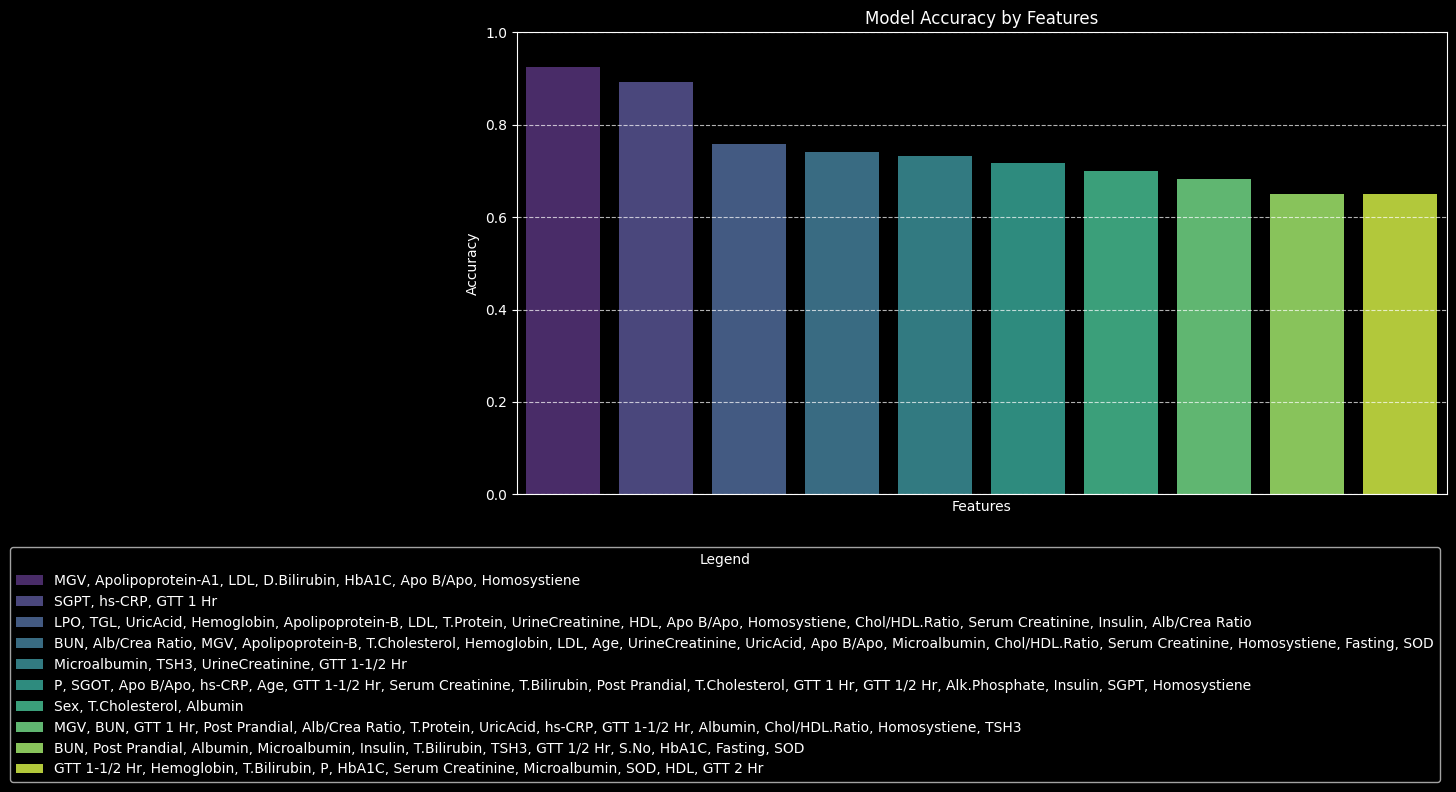

In [93]:
accuracy_results = pd.DataFrame(accuracy_results, columns=["Features", "Accuracy"])
sorted_results = accuracy_results.sort_values(by=["Accuracy"], ascending=False)
sorted_results["Features"] = sorted_results["Features"].apply(lambda x: ', '.join(x))[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x="Features", y="Accuracy", data=sorted_results, palette="viridis", hue="Features")
plt.ylabel('Accuracy')
plt.xlabel('Features')
plt.title('Model Accuracy by Features')
plt.ylim(0, 1)  
plt.xticks([])  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Legend', loc='upper right', bbox_to_anchor=(1, -0.1))
plt.show()